<a href="https://colab.research.google.com/github/bonareri/Machine_Learning_1/blob/main/Online_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Online Retail Customer Segmentation

The aim of this machine learining project is to perform customer segmentation for an online retail business.
Customer segmentation involves dividing a customer base into distinct groups on shared characteristics, behaviors or preferences.

**Dataset**: The project utilizes a dataset containing relevant information about online retail customers. The dataset includes features suchs as customer demo.

**Objective**: To apply machine learning techniques to segment the online retail customers into meaningful groups based on their purchasing behavior and characteristics.


## Problem Statement

Identifying the major customer segments on the transactional dataset which contains all the transactions occurring between 01/12/2010 and 09/12/2010 for an online retail store.

###**Data Description**
**Attribute Information**
- **Invoice No** - Nominal 6-digit integral number uniquely assigned to each transaction. If this code starts with 'C', it indicates it's a cancellation.
- **Stock Code** - Product (item) code. Nominal 5-digit integral number uniquely assigned to each distinct product.
-**Description** - Product (item) name. Nominal
-**Quantity** - The quantity of each product(item) per transaction. Numeric
-**Invoice Date** - Invoice Date and Time. Numeric, the day and time when each transaction was generated.
-**Unit Price** - Numeric, Product price per unit in sterling.
-**Customer ID** - Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
-**Country** - Country name. Nominal, the name of the country where each cutomer resides.



##1. Importing Liblaries

In [63]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [113]:
# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Model Building
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

# Metrics (optional, for evaluating models after PCA)
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, f1_score, confusion_matrix

In [65]:
#load data
df = pd.read_excel('/content/Online Retail.xlsx')

In [66]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Wrangling

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Observation
- Datatype of **InvoiceDate** is object and needs to be converted to datetime.
- If **InvoiceNo** starts with C it means it's a cancellation. We need to drop this entries.
- There are null values in **CustomerID** and **Description**

In [68]:
#Explore the unique values of each attribute
print("Number of transactions: ", df['InvoiceNo'].nunique())
print("Number of products bought: ",df['StockCode'].nunique())
print("Number of customers:", df['CustomerID'].nunique())
print ("Number of countries: ", df['Country'].nunique())

Number of transactions:  25900
Number of products bought:  4070
Number of customers: 4372
Number of countries:  38


In [69]:
#get the cancelled orders
cancelled_orders = df[df['InvoiceNo'].astype(str).str.startswith('C')]
cancelled_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [70]:
#check how many orders contain cancelled orders
print("Cancelled orders: ", len(cancelled_orders))

Cancelled orders:  9288


In [71]:
#percentage of cancelled orders in total orders
total_orders = df['InvoiceNo'].nunique()
cancelled_number = len(cancelled_orders)
print("Percentage of cancelled orders: ", round(cancelled_number/total_orders*100, 2))

Percentage of cancelled orders:  35.86


In [72]:
#check the null values count
df.isnull().sum().sort_values(ascending=False)

,0
CustomerID,135080
Description,1454
InvoiceNo,0
StockCode,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


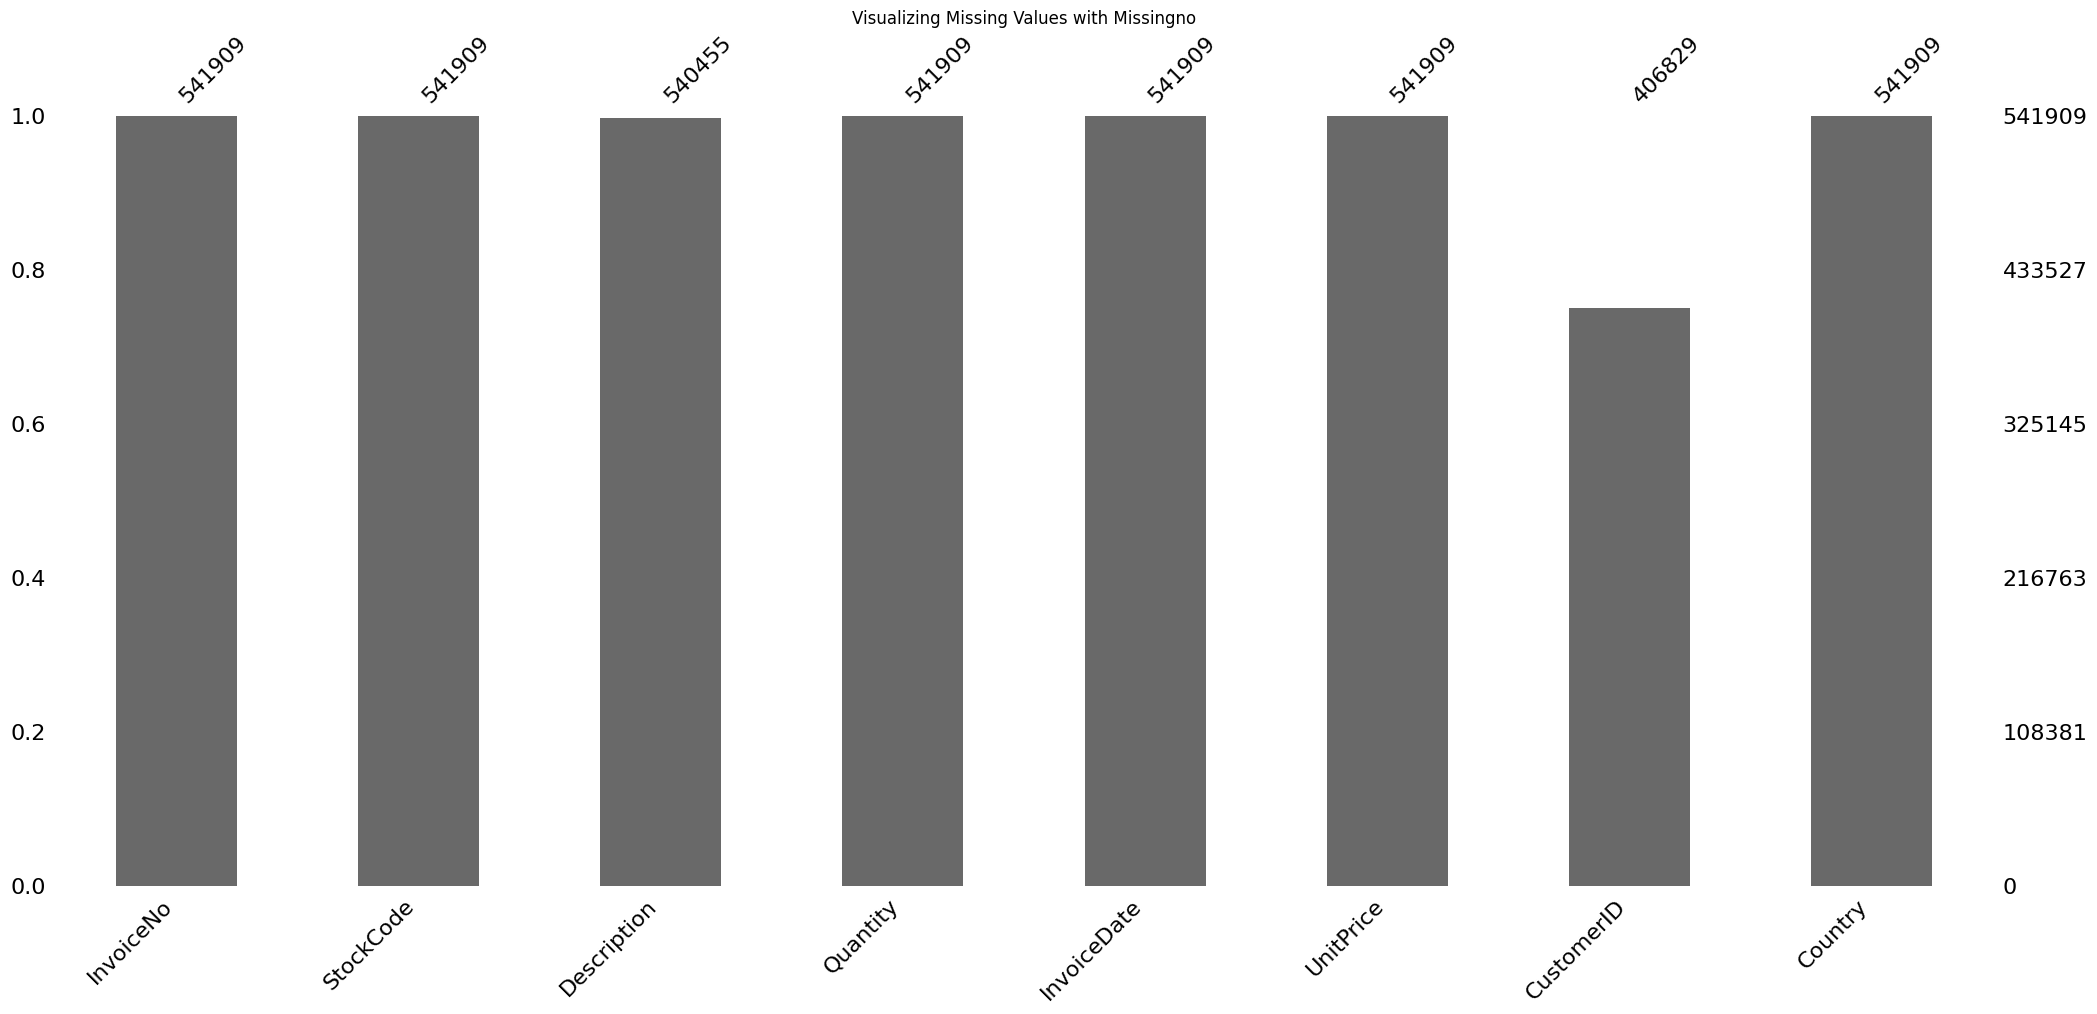

In [73]:
# Visualize null values using missingno heatmap
plt.figure(figsize=(5, 5))
msno.bar(df)
plt.title('Visualizing Missing Values with Missingno')
plt.show()

###Observations
- Missing values in CustomerID and Description
- CustomerID is the identification feature and so if its missing it won't help in anlysis so it has to be dropped.

## Data Cleaning

In [74]:
#drop null values
df.dropna(inplace=True)

In [75]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [76]:
# Changing the datatype to str
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

In [77]:
#Drop cancelled orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [78]:
#checking how many values are present where UnitPrice == 0
len(df[df['UnitPrice'] == 0])

40

In [79]:
#drop rows where the UnitPrice ==0
df = df[df['UnitPrice'] != 0]

In [80]:
#checking UnitPrice values greater than 0
df[df['UnitPrice'] > 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [81]:
df.shape

(397884, 8)

## Feature Engineering

In [82]:
#Converting Invoice Date to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [83]:
# Extract the year from 'InvoiceDate' and create a new 'year' column
df['year'] = df['InvoiceDate'].apply(lambda x: x.year)

# Extract the month from 'InvoiceDate' and create a new 'month' column
df['month_num'] = df['InvoiceDate'].apply(lambda x: x.month)

# Extract the day from 'InvoiceDate' and create a new 'day' column
df['day_num'] = df['InvoiceDate'].apply(lambda x: x.day)

# Extract the hour from 'InvoiceDate' and create a new 'hour' column
df['hour'] = df['InvoiceDate'].apply(lambda x: x.hour)

# Extract the minute from 'InvoiceDate' and create a new 'minute' column
df['minute'] = df['InvoiceDate'].apply(lambda x: x.minute)


In [84]:
# Extract the month name from 'InvoiceDate' and create a new 'month_name' column
df['Month'] = df['InvoiceDate'].dt.month_name()

In [85]:
# Extract the day name from 'InvoiceDate' and create a new 'day_name' column
df['Day'] = df['InvoiceDate'].dt.day_name()

In [86]:
#Analyze country with more customers
df['TotalAmount'] = df['Quantity']* df['UnitPrice']

In [87]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month_num,day_num,hour,minute,Month,Day,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,8,26,December,Wednesday,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,December,Wednesday,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,8,26,December,Wednesday,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,December,Wednesday,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,December,Wednesday,20.34


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   year         397884 non-null  int64         
 9   month_num    397884 non-null  int64         
 10  day_num      397884 non-null  int64         
 11  hour         397884 non-null  int64         
 12  minute       397884 non-null  int64         
 13  Month        397884 non-null  object        
 14  Day          397884 non-null  object        
 15  TotalAmount  397884 non-null  float64  

##2. Exploratory Data Analysis

In [88]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'year', 'month_num', 'day_num',
       'hour', 'minute', 'Month', 'Day', 'TotalAmount'],
      dtype='object')

In [20]:
#analysis on quantitative data
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [94]:
top_10_products = df['Description'].value_counts().reset_index().rename(columns={'index': 'Product_name', 'Description': 'Count'}).head(10)
top_10_products

,Count,count
0,WHITE HANGING HEART T-LIGHT HOLDER,2028
1,REGENCY CAKESTAND 3 TIER,1723
2,JUMBO BAG RED RETROSPOT,1618
3,ASSORTED COLOUR BIRD ORNAMENT,1408
4,PARTY BUNTING,1396
5,LUNCH BAG RED RETROSPOT,1316
6,SET OF 3 CAKE TINS PANTRY DESIGN,1159
7,LUNCH BAG BLACK SKULL.,1105
8,POSTAGE,1099
9,PACK OF 72 RETROSPOT CAKE CASES,1068


In [99]:
#Bottom 10 items in terms of description
bottom_10_products = df['Description'].value_counts().reset_index().rename(columns={'index': 'Product_name', 'Description': 'Count'}).tail(10)
bottom_10_products

,Count,count
3867,BLUE FELT HANGING HEART WITH FLOWER,1
3868,GLASS CAKE COVER AND PLATE,1
3869,CRACKED GLAZE EARRINGS RED,1
3870,SCALLOP SHELL SOAP DISH,1
3871,NECKLACE+BRACELET SET PINK DAISY,1
3872,RUBY GLASS CLUSTER EARRINGS,1
3873,PINK CHRYSANTHEMUMS ART FLOWER,1
3874,72 CAKE CASES VINTAGE CHRISTMAS,1
3875,"WALL ART , THE MAGIC FOREST",1
3876,"PAPER CRAFT , LITTLE BIRDIE",1


In [100]:
#Top 10 items in terms of stock code
top_10_stock_codes = df['StockCode'].value_counts().reset_index().rename(columns={'index': 'Stock_code', 'StockCode': 'Count'}).head(10)
top_10_stock_codes

,Count,count
0,85123A,2035
1,22423,1723
2,85099B,1618
3,84879,1408
4,47566,1396
5,20725,1317
6,22720,1159
7,20727,1105
8,POST,1099
9,23203,1098


In [103]:
#Top 10 frequent customers
top_10_customers = df['CustomerID'].value_counts().reset_index().rename(columns={'index': 'Customer_ID', 'CustomerID': 'Count'}).head(10)
top_10_customers

,Count,count
0,17841.0,7847
1,14911.0,5675
2,14096.0,5111
3,12748.0,4595
4,14606.0,2700
5,15311.0,2379
6,14646.0,2076
7,13089.0,1818
8,13263.0,1677
9,14298.0,1637


In [107]:
#Top 10 countries in terms of customers
top_10_countries = df['Country'].value_counts().reset_index().rename(columns={'index': 'Country', 'Country': 'Customer_count'}).head(10)
top_10_countries

,Customer_count,count
0,United Kingdom,354321
1,Germany,9040
2,France,8341
3,EIRE,7236
4,Spain,2484
5,Netherlands,2359
6,Belgium,2031
7,Switzerland,1841
8,Portugal,1462
9,Australia,1182


In [108]:
#Bottom 10 countries in terms of customers
bottom_10_countries = df['Country'].value_counts().reset_index().rename(columns={'index': 'Country', 'Country': 'Customer_count'}).tail(10)
bottom_10_countries

,Customer_count,count
27,Malta,112
28,United Arab Emirates,68
29,European Community,60
30,RSA,57
31,Lebanon,45
32,Lithuania,35
33,Brazil,32
34,Czech Republic,25
35,Bahrain,17
36,Saudi Arabia,9


In [106]:
#Top 10 countries in terms of TotalAmount Spent
top_10_countries_amount = df.groupby('Country')['TotalAmount'].sum().reset_index().sort_values(by='TotalAmount', ascending=False).head(10)
top_10_countries_amount

,Country,TotalAmount
35,United Kingdom,7308391.554
23,Netherlands,285446.340
10,EIRE,265545.900
14,Germany,228867.140
13,France,209024.050
0,Australia,138521.310
30,Spain,61577.110
32,Switzerland,56443.950
3,Belgium,41196.340
31,Sweden,38378.330


In [111]:
#Month with the highest sales
monthly_sales = df['Month'].value_counts().reset_index().rename(columns={'index': 'Month', 'Month': 'Sales_count'})
monthly_sales

,Sales_count,count
0,November,64531
1,October,49554
2,December,43461
3,September,40028
4,May,28320
5,June,27185
6,March,27175
7,August,27007
8,July,26825
9,April,22642


In [112]:
#sales count on different days
daily_sales = df['Day'].value_counts().reset_index().rename(columns={'index': 'Day', 'Day': 'Sales_count'})
daily_sales

,Sales_count,count
0,Thursday,80035
1,Wednesday,68885
2,Tuesday,66473
3,Monday,64893
4,Sunday,62773
5,Friday,54825


## Data Preprocessing

**Key Features for Clustering:**
1. total_spend: Total money spent by the customer (sum of TotalAmount).
2. total_quantity: Total quantity of products bought by the customer.
3. avg_price: Average price of the products bought by the customer.
4. num_transactions: Number of unique transactions the customer made.

In [116]:
# Aggregating features per CustomerID
df_customer = df.groupby('CustomerID').agg(
    total_spend=('TotalAmount', 'sum'),
    total_quantity=('Quantity', 'sum'),
    avg_price=('UnitPrice', 'mean'),
    num_transactions=('InvoiceNo', 'nunique')
).reset_index()

# Inspect the aggregated customer data
df_customer.head()

,CustomerID,total_spend,total_quantity,avg_price,num_transactions
0,12346.0,77183.60,74215,1.040000,1
1,12347.0,4310.00,2458,2.644011,7
2,12348.0,1797.24,2341,5.764839,4
3,12349.0,1757.55,631,8.289041,1
4,12350.0,334.40,197,3.841176,1


**Standardize Features for KMeans:**

In [117]:
# Selecting the features for clustering
X = df_customer[['total_spend', 'total_quantity', 'avg_price', 'num_transactions']]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Model Building

###1. KMeans Clustering

To choose the number of clusters for KMeans clustering based on the elbow method, compute the within-cluster sum of squares (WSS), also known as inertia, for different values of k (number of clusters).

**Steps to apply the elbow method:**
1. **Fit KMeans for different values of k.**
2. **Calculate the inertia** for each value of k.
3. **Plot the inertia** against the number of clusters to identify the elbow point.

### Applying Elbow Method

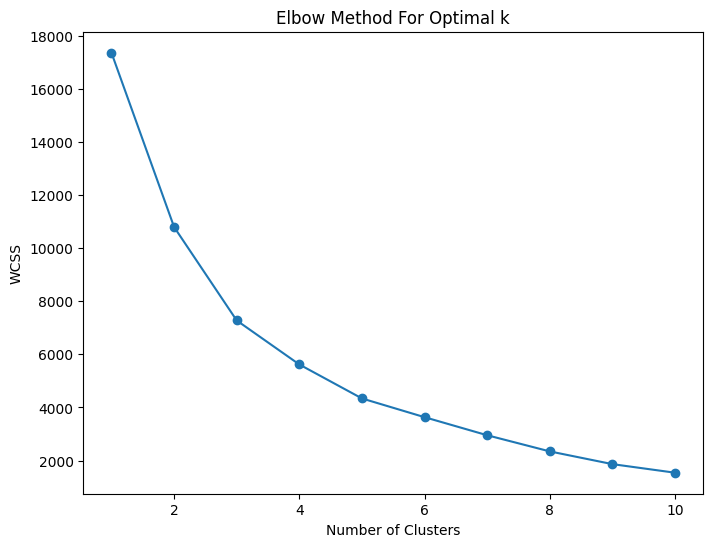

In [127]:
from sklearn.decomposition import PCA

# Assuming 'df_customer' contains the relevant customer data
# Select features for clustering (e.g., 'total_spend', 'total_quantity', 'avg_price', 'num_transactions')
X = df_customer[['total_spend', 'total_quantity', 'avg_price', 'num_transactions']]

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_data, columns=['total_spend', 'total_quantity', 'avg_price', 'num_transactions'])

# Elbow Method to determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

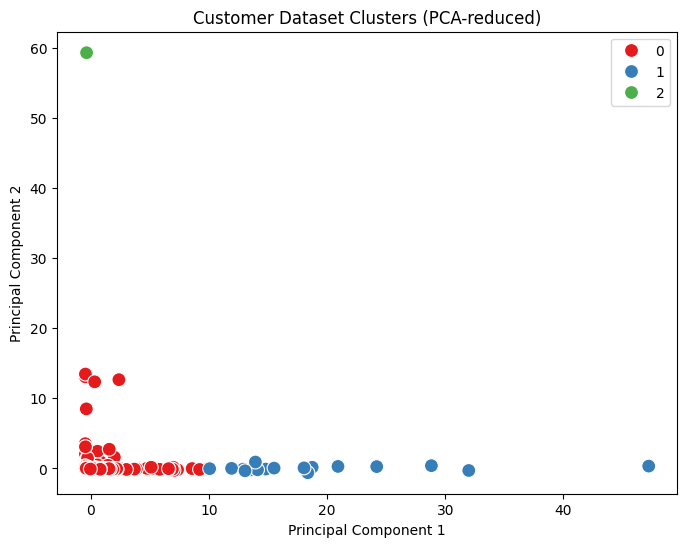

In [128]:
# Apply KMeans with 3 clusters (based on the elbow plot)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(scaled_df)

# Add the cluster labels to the DataFrame
df_customer['Cluster'] = kmeans.labels_

# Apply PCA to reduce the features to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df)

# Create a DataFrame for the PCA components
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df_customer['Cluster']

# Plot the clusters in 2D space
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=100)
plt.title('Customer Dataset Clusters (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()